### Prueba 1 - Hito 2 - Javier Rojas Benitez - G56

In [1]:
import importlib

import pandas as pd
import numpy as np
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from funciones_auxiliares_hito_2 import codificar_sentimientos

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 10)

In [2]:
df = pd.read_csv("input/training_tweets.csv").drop(columns="Unnamed: 0")


# Preprocesamiento

## Variables independientes

In [3]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

STOPWORDS_INGLES = set(stopwords.words("english"))

In [4]:
def preprocesar_texto_lema(texto):
    tokens = texto.split()
    filtro_stop_words = [palabra for palabra in tokens if palabra not in STOPWORDS_INGLES]
    lematizacion = [lemmatizer.lemmatize(palabra, "v") for palabra in filtro_stop_words]

    texto_juntado = " ".join(lematizacion)

    return texto_juntado


def preprocesar_texto_stem(texto):
    tokens = texto.split()
    filtro_stop_words = [palabra for palabra in tokens if palabra not in STOPWORDS_INGLES]
    stemmizacion = [stemmer.stem(palabra, "v") for palabra in filtro_stop_words]

    texto_juntado = " ".join(stemmizacion)

    return texto_juntado


In [5]:
df["procesados_lema"] = df.content.str.lower().apply(preprocesar_texto_lema)
df["procesados_stem"] = df.content.str.lower().apply(preprocesar_texto_stem)


In [6]:
def obtener_100_palabras_mas_frecuentes(serie_textos):
    """Funcion que permite obtener las 100 palabras mas frecuentes de una lista de
    textos

    :param serie_palabras: Array de textos a analizar
    :type serie_palabras: pd.Series

    :returns: Las 100 palabras mas frecuentes para el array de textos
    :rtype: pd.DataFrame
    """
    count_vectorizer = CountVectorizer(stop_words="english")
    count_vectorizer_fit = count_vectorizer.fit_transform(serie_textos)
    words = count_vectorizer.get_feature_names_out()
    words_freq = count_vectorizer_fit.toarray().sum(axis=0)

    conteo_palabras = pd.DataFrame(words_freq, index=words, columns=["conteo"])
    conteo_palabras = conteo_palabras.sort_values("conteo", ascending=False)
    conteo_palabras = conteo_palabras.reset_index(names="palabra")

    return conteo_palabras

In [7]:
df_lema = obtener_100_palabras_mas_frecuentes(df["procesados_lema"])
df_stem = obtener_100_palabras_mas_frecuentes(df["procesados_stem"])

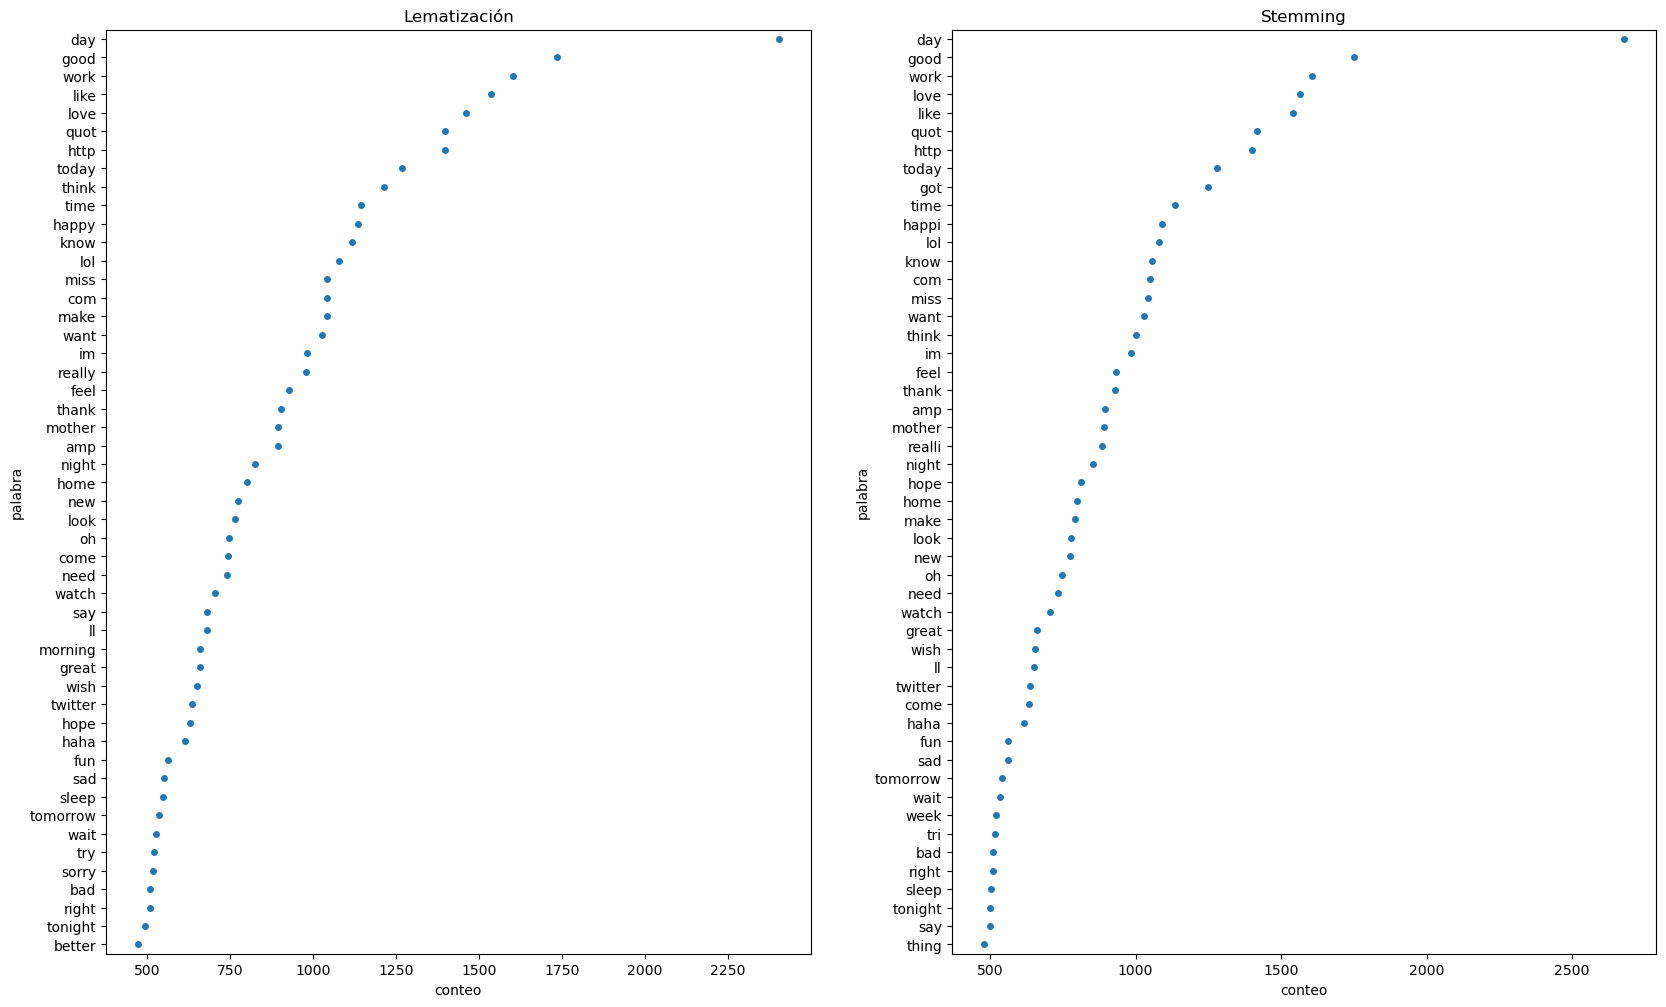

La cantidad de palabras distintas en la lematizacion fue: 37681
La cantidad de palabras distintas en el stemming fue: 37497


In [8]:
figure, axis = plt.subplots(1, 2, figsize=(20, 12))

sns.stripplot(data=df_lema.head(50), x="conteo", y="palabra", ax=axis[0])
sns.stripplot(data=df_stem.head(50), x="conteo", y="palabra", ax=axis[1])
axis[0].set_title("Lematización")
axis[1].set_title("Stemming")
plt.show()


print(f"La cantidad de palabras distintas en la lematizacion fue: {df_lema.shape[0]}")
print(f"La cantidad de palabras distintas en el stemming fue: {df_stem.shape[0]}")

- La lematización y el stemming presentaron un patrón de palabras bastante similares entre sí.

- La lematización presentó 37681 palabras distintas, mientras el stemming presentó 37497 palabras
distintas. Si nos basamos en este parámetro, el stemming es la mejor táctica para preprocesar el texto
y utilizarlo en un modelo de Machine Learning. Esto, ya que el modelo será más parsimonioso.

- La representación de las palabras con la lematización es más fiel al lenguaje que el stemming.
Ejemplos de este fenómeno ocurre con las siguientes palabras:

|Lematización|Stemming|
|-----------|--------|
happy|happi|
really|realli|

Teniendo en cuenta todos los resultados previos, **se utilizará la técnica de lematización para la
confección de cada modelo**. Esto, porque tiene una mejor interpretación de los datos, a pesar de
ser más costoso computacionalmente.

# Implementacion de modelos

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, roc_auc_score

In [10]:
grilla_logistic = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "solver": ["lbfgs", "liblinear", "sag", "saga"],
}

grilla_arbol_clasificacion = {
    "max_depth": range(3, 11),
    "max_leaf_nodes": range(1, 6),
    "criterion": ["gini", "entropy"],
}

grilla_random_forest = {
    "max_depth": range(3, 11),
    "n_estimators": range(100, 1001, 100),
    "max_features": ["sqrt", "log2", None],
}

grilla_svm = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": [1, 0.1, 0.01, 0.001],
}

grilla_naive_bayes = {"alpha": [0.01, 0.1, 1, 10], "fit_prior": [True, False]}

# Division de Muestra

In [11]:
X = CountVectorizer(stop_words="english").fit_transform(df["procesados_lema"])
y = codificar_sentimientos(df["sentiment"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.335, random_state=1)

In [36]:
modelo_logistic = GridSearchCV(
    LogisticRegression(), grilla_logistic, cv=5, scoring="accuracy", verbose=5, n_jobs=-1
)

modelo_arbol = GridSearchCV(
    DecisionTreeClassifier(),
    grilla_arbol_clasificacion,
    cv=5,
    scoring="accuracy",
    verbose=5,
    n_jobs=-1,
)

modelo_random_forest = GridSearchCV(
    RandomForestClassifier(), grilla_random_forest, cv=5, scoring="accuracy", verbose=5, n_jobs=-1
)

modelo_svm = GridSearchCV(SVC(), grilla_svm, cv=5, scoring="accuracy", verbose=5, n_jobs=-1)

modelo_naive_bayes = GridSearchCV(
    MultinomialNB(), grilla_naive_bayes, cv=5, scoring="accuracy", verbose=5, n_jobs=-1
)

In [42]:
def resumir_resultados_grid_cv(diccionario_resultados):
    df_resultados = pd.DataFrame(diccionario_resultados)
    df_resultados["params_str"] = df_resultados["params"].astype(str)

    return df_resultados


def graficar_resultados_grid_cv(resultado_df):
    sns.lineplot(data=resultado_df, x="params_str", y="mean_test_score", marker="o")
    plt.tick_params(axis="x", labelrotation=90)


def analizar_resultados_grid_cv(diccionario_resultados):
    df_resultados = resumir_resultados_grid_cv(diccionario_resultados)
    graficar_resultados_grid_cv(df_resultados)

    return df_resultados


def entrenar_y_obtener_desempeno_modelo_en_grilla(modelo_grilla, X_train, X_test, y_train, y_test):
    modelo_grilla.fit(X_train, y_train)
    print(f'\n\n--------------Resultados Conjunto de Entrenamiento-----------------')
    print("Los resultados en la busqueda de hiperparametros son:")
    resultados_grilla = analizar_resultados_grid_cv(modelo_grilla.cv_results_)
    plt.show()
    print(f'Los mejores parametros fueron: {modelo_grilla.best_params_}')
    print(f'El mejor desempeno fue: {modelo_grilla.best_score_}')


    print(f'\n\n--------------Resultados Conjunto de Validacion-----------------')
    yhat = modelo_grilla.predict(X_test)
    roc = roc_auc_score(y_test, yhat)
    print("Los resultados en el conjunto de validacion son:")
    print(classification_report(y_test, yhat))
    print(f"El ROC fue de: {roc}")

    print(f'---------------------------------------------------------------------')

    return modelo_grilla, resultados_grilla

Fitting 5 folds for each of 24 candidates, totalling 120 fits


--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


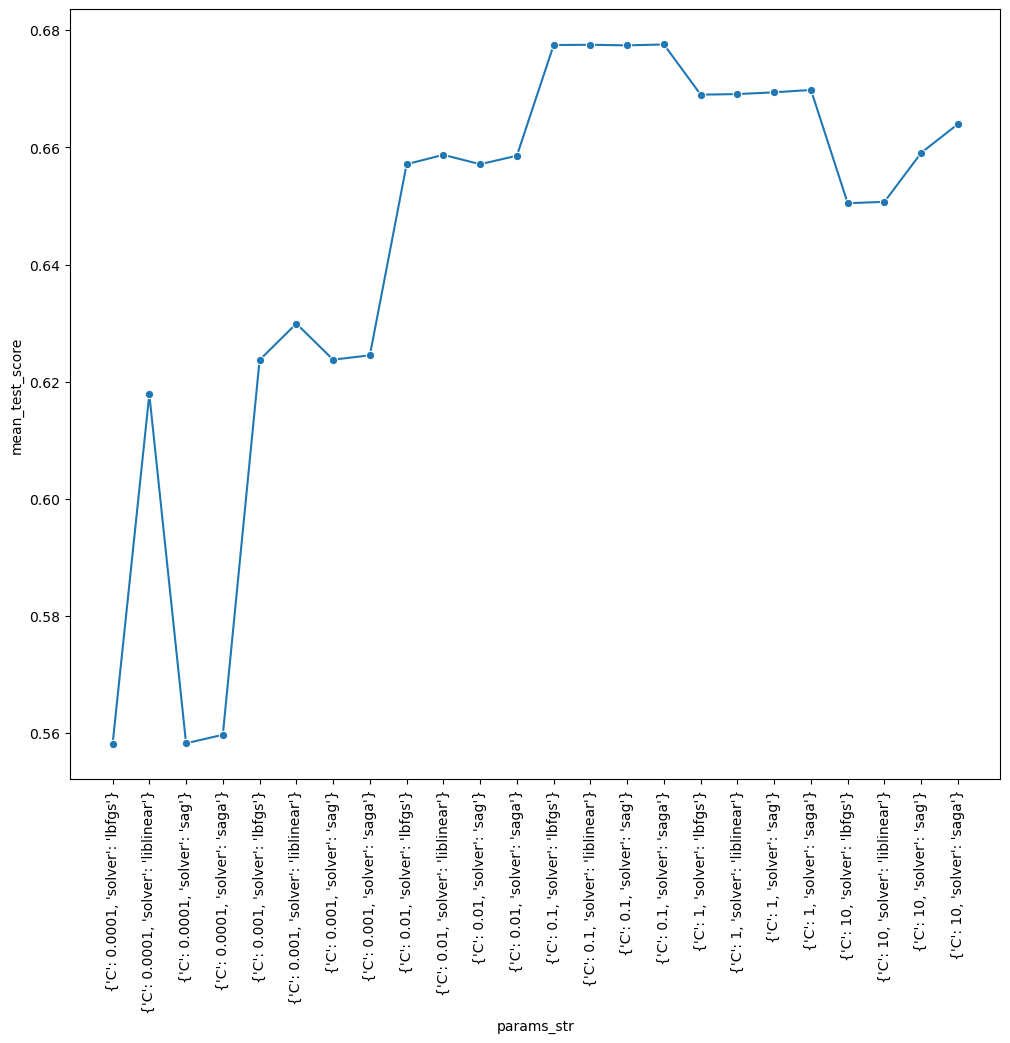

Los mejores parametros fueron: {'C': 0.1, 'solver': 'saga'}
El mejor desempeno fue: 0.677593984962406


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           0       0.66      0.73      0.69      5160
           1       0.68      0.61      0.65      4890

    accuracy                           0.67     10050
   macro avg       0.67      0.67      0.67     10050
weighted avg       0.67      0.67      0.67     10050

El ROC fue de: 0.6699267608313122
---------------------------------------------------------------------


In [43]:
modelo_logistic, resultados_logistic = entrenar_y_obtener_desempeno_modelo_en_grilla(
    modelo_logistic, X_train, X_test, y_train, y_test
)

In [16]:
modelo_arbol.fit(X_train, y_train)


Fitting 5 folds for each of 80 candidates, totalling 400 fits


KeyboardInterrupt: 

In [20]:
print(classification_report(y_test, modelo_logistic.predict(X_test)))


              precision    recall  f1-score   support

           0       0.66      0.73      0.69      5160
           1       0.68      0.61      0.65      4890

    accuracy                           0.67     10050
   macro avg       0.67      0.67      0.67     10050
weighted avg       0.67      0.67      0.67     10050



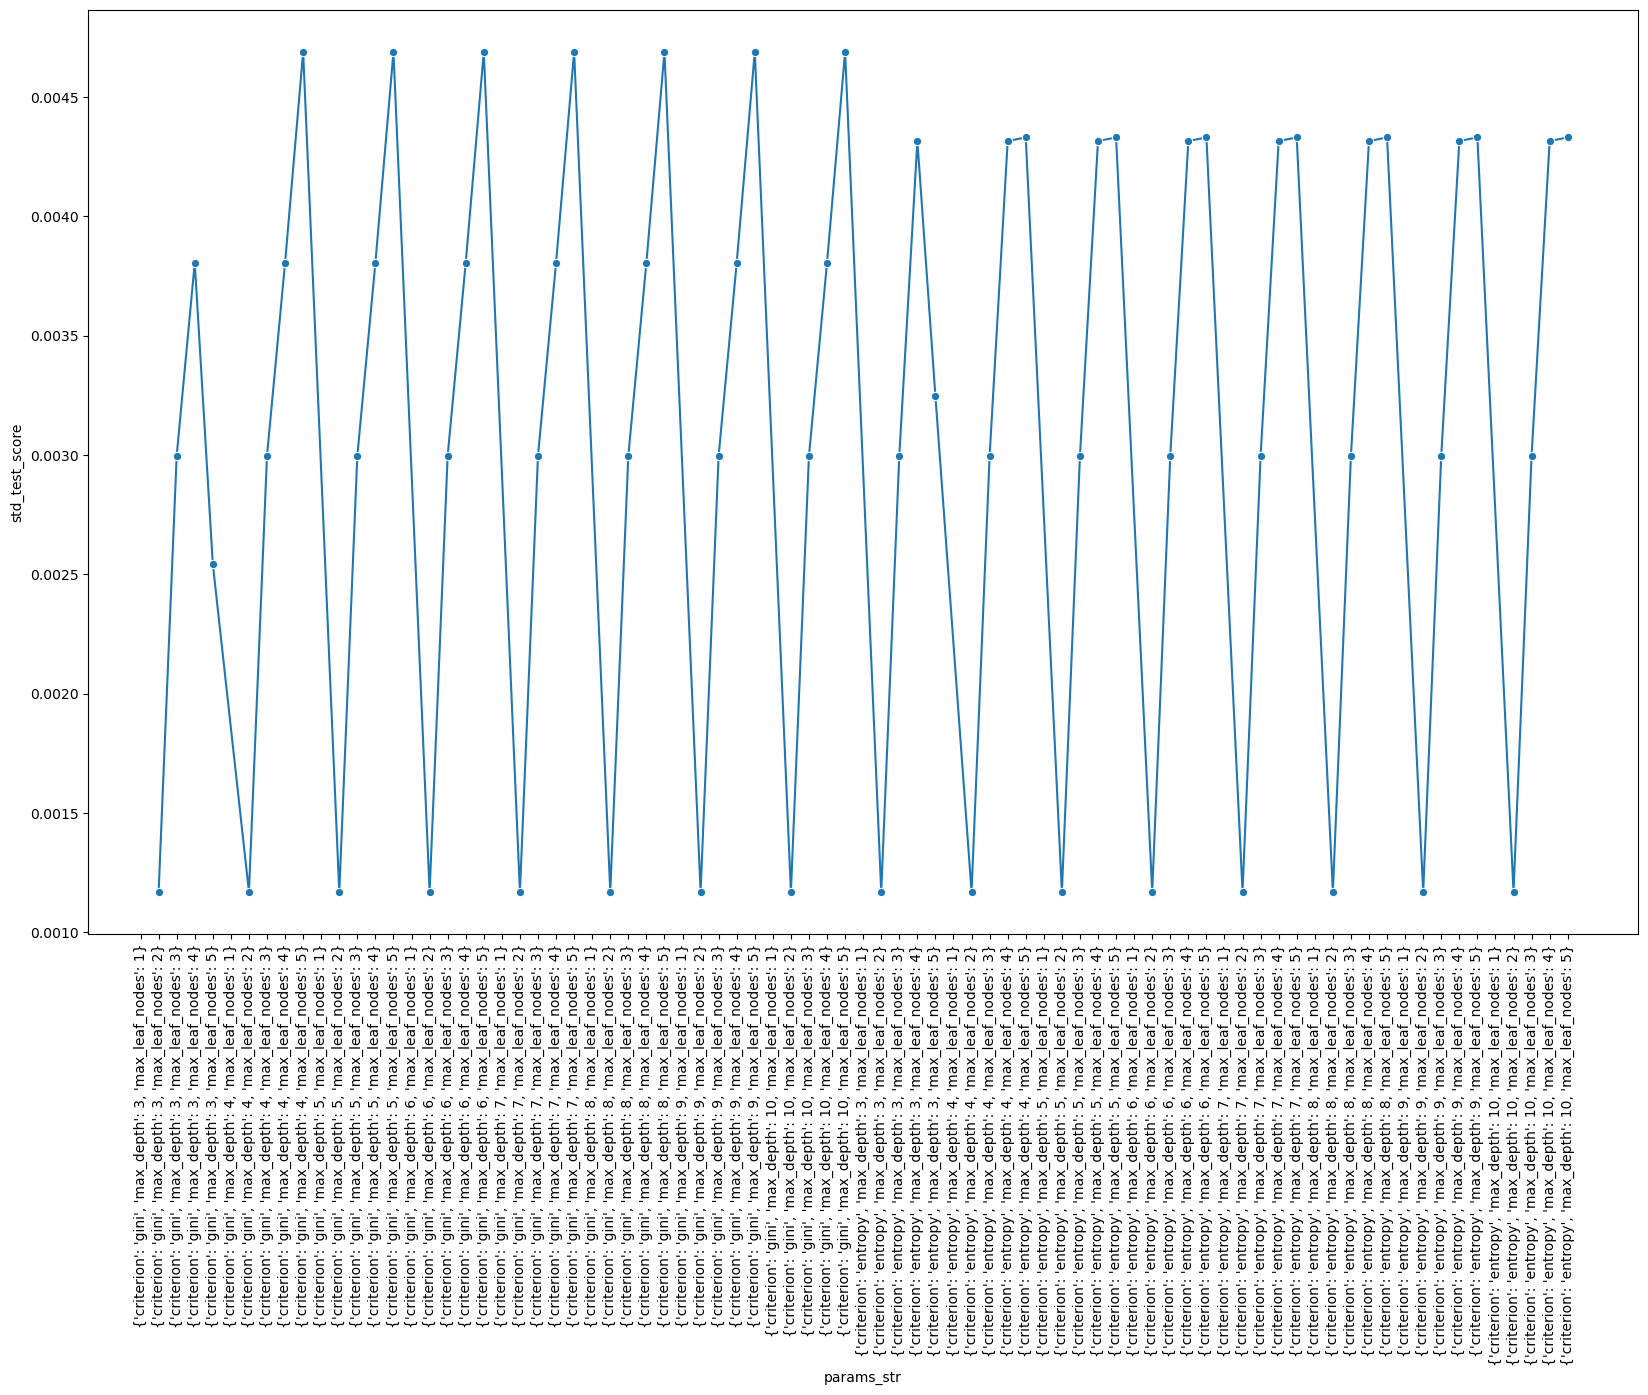

In [ ]:
plt.figure(figsize=(20, 12))
resultados_arbol = analizar_resultados_grid_cv(modelo_arbol.cv_results_)


In [ ]:
modelo_svm.fit(X_train, y_train)
resultados_svm = analizar_resultados_grid_cv(modelo_svm.cv_results_)


Fitting 5 folds for each of 96 candidates, totalling 480 fits


KeyboardInterrupt: 